In [21]:
using Plots
using StatsBase
using Random
using Printf
using Distributions
using BenchmarkTools
using QuadGK
using ForwardDiff

a = 0.1
START
258.566721 seconds (10.98 M allocations: 8.556 GiB, 0.37% gc time, 0.05% compilation time)
-----2-sweep-----
<x>  = -0.0018
<xx> = 0.2480
<H>  = 0.9899


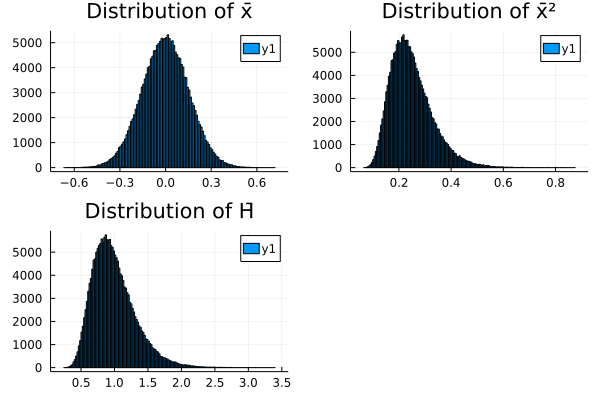

In [140]:
#(1+1)次元の調和振動子を経路積分で求める．

#2021-8-31 ゼミ後更新,改良
#2021-9-6  最終更新日

#具体的に計算できるのは　位置の期待値　２乗変位の期待値　となる．
#ハミルトニアンの期待値も計算してみる．Virialの定理から，調和振動子に対してはμ²x²の期待値に等しくなる．
#さらにハミルトニアンの期待値計算を実行する．
#これらを計算することを目標とする．

function V(x)
    μ=2.0
    0.5*μ^2*x^2
end

function dVdx(x)
    ForwardDiff.derivative(V,x)
end

function S(x,q)
    _, _, _, _, _, N, m, ħ, ti, tf, c = q
    a      = (tf-ti)/N
    action = 0.0
    action = sum(0.5*m*(x[i+1]-x[i])^2/a + a*V(x[i]) for i=1:N-1)
    return action/ħ
end

# q = (n_sweep,per,ave_X,ave_XX,ave_H,N,m,ħ,ti,tf,c)
# x[]=(x1,x2,...,xn+1)の更新を１回実行する
function MP_check(x_new,q)
    _, _, _, _, _, N, m, ħ, ti, tf, c = q
    a     = (tf-ti)/N
    x_old = zeros(N+1)
    for i=2:N
        @. x_old = x_new 
        x_new[i] += rand(Uniform(-c,c))
        r = rand()
        if r < exp(-S(x_new,q)+S(x_old,q))
            x_new[i] = x_new[i]
        else
            x_new[i] = x_old[i]
        end
    end
end

#各配位に対して，<平均の位置>を求める．これは，ある量子系=配位に対して位置を測定することに相当する．
function ave_x(x,n)
    ret = sum(x[i] for i=1:n+1)
    return ret/(n+1)
end
function ave_xx(x,n)
    ret = sum(x[i]^2 for i=1:n+1)
    return ret/(n+1)
end
function ave_Hamiltonian(x,n)
    m=1.0
    Hamiltonian = 0.0
    #Hamiltonian = sum(0.5*m*x[i]^2 + V(x[i]) for i=1:n-1) 
    Hamiltonian = sum(0.5*x[i]*dVdx(x[i]) + V(x[i]) for i=1:n-1) 
    return Hamiltonian/(n-1)
end

function Main_sweep(Ω,x,para)
    n_sweep, per, ave_X, ave_XX, ave_H, N, = para
    ite = 1; count = 1
    for m=1:n_sweep
        MP_check(x,para)
            if (m % per == 0)
                ave_X[count]  = ave_x(x,N)
                ave_XX[count] = ave_xx(x,N)
                ave_H[count]  = ave_Hamiltonian(x,N)
                Ω[:,count]   .= x[:]                    #configurationを取り出す
                count += 1
            end
        ite = m
    end
end

#--------Main-------------------------------------------------------------------------------

N       = 1_00          #時間分割数
ti      = 0             #始時刻
tf      = 10            #終時刻
a       = (tf-ti)/N     #時間幅
c       = 1             #乱数幅
m       = 1             #質量
ħ       = 1             #Dirac定数
x       = 1*ones(N+1)   #初期配位
x[1]    = 0.0           #境界１
x[N+1]  = 0.0           #境界２
@show a                 #格子間隔

n_sweep = 10^7
ite     = 1
count   = 1
per     = 50
n_config= div(n_sweep,per)
ave_X   = zeros(n_config)
ave_XX  = similar(ave_X)
ave_H   = similar(ave_X)

Ω       = zeros(N+1,n_config)

#---- parameter vector --------------------------------------------------------------------
q = (n_sweep,per,ave_X,ave_XX,ave_H,N,m,ħ,ti,tf,c)


#---- 初期配位プロット -----------------------------------------------------------------------
p1 = plot([x x],st=[:scatter :line],label="Inital",lw=2,mc=RGB(0,0,1),lc=RGB(0,0,1))

@printf("START\n")

@time Main_sweep(Ω,x,q)
MP_check(x,q)

@printf("-----%d-sweep-----\n",ite+1)

#---- プロット ------------------------------------------------------------------------------
p3 = plot([x x],st=[:scatter :line],label="Final config.",lw=2,lc=:green,mc=:green)

plot([ave_X ave_XX],label=["x̄" "x̄²"])

#期待値を計算する関数類もまとめておきたい．

exp_x  = sum(ave_X[i]  for i=1:length(ave_X))/length(ave_X)
exp_xx = sum(ave_XX[i] for i=1:length(ave_XX))/length(ave_XX)
exp_H  = sum(ave_H[i]  for i=1:length(ave_H))/length(ave_H)

@printf("<x>  = %6.4f\n",exp_x)
@printf("<xx> = %6.4f\n",exp_xx)
@printf("<H>  = %6.4f\n",exp_H)

p_ave_x  = plot(ave_X, st=:histogram, title="Distribution of x̄")
p_ave_xx = plot(ave_XX,st=:histogram, title="Distribution of x̄²")
p_ave_H  = plot(ave_H, st=:histogram, title="Distribution of H̄")

plot(p_ave_x,p_ave_xx,p_ave_H)


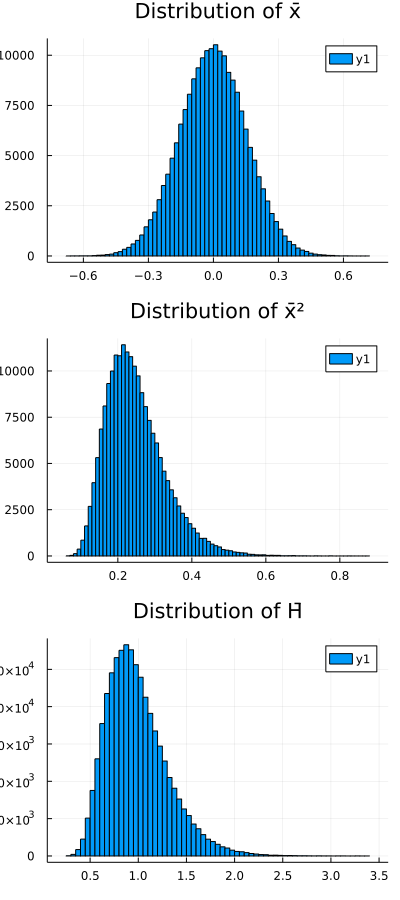

In [170]:
p_ave_x  = plot(ave_X, st=:histogram, title="Distribution of x̄",nbins=80)
p_ave_xx = plot(ave_XX,st=:histogram, title="Distribution of x̄²",nbins=80)
p_ave_H  = plot(ave_H, st=:histogram, title="Distribution of H̄",nbins=80)

plot(p_ave_x,p_ave_xx,p_ave_H,layout=(3,1),size=(400,900))



test_deriv(1) = 0.25


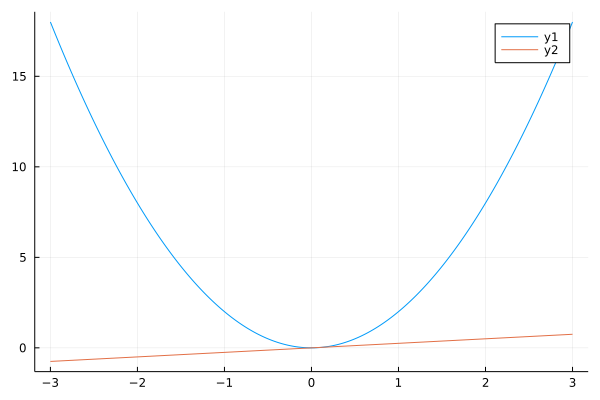

In [32]:


function test_f(x)
    a = 0.5 
    return 0.5*a^2*x^2
end

function test_deriv(x) 
    ForwardDiff.derivative(test_f,x)
end

@show test_deriv(1)

xr = range(-3,3,length=1000)

plot(xr,[test_f.(xr,a) test_deriv.(xr)])

In [141]:
@show n_c = div(n_sweep,per)
@show N+1

@show CONF = ones(5,4)

#testx = ones(5)
testx = (1,2,3,4,5)

    CONF[:,1] .= testx[:]

abs(-2)

n_c = div(n_sweep, per) = 200000
N + 1 = 101
CONF = ones(5, 4) = [1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0]


2

401.780317 seconds (12.24 G allocations: 213.289 GiB, 6.16% gc time)


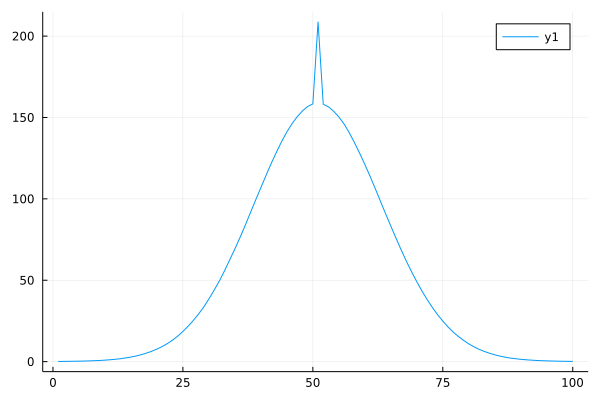

In [158]:
#配位を取り出したので解析する．

conf1 = Ω[1:N+1,1]
conf2 = Ω[1:N+1,2]
conf3 = Ω[1:N+1,3]
#Ω

plot([conf1 conf2 conf3])

size(Ω)

#setting
x_axis_range = 4 # -1~1
x_axis_N     = 100
dx           = x_axis_range/x_axis_N
psi          = zeros(x_axis_N)
    
@time for j=1:n_config
    conf_dum = Ω[1:N+1,j]
        for k=1:N+1
            for m=1:x_axis_N
                xm = -2.0 + dx*(m-1)
                δx = abs(conf_dum[k] - xm)
                if δx < dx 
                    psi[m] += 1 # k -> m
                end
            end
        end
end

Coeff = 1.0/(dx*n_config)

psi .*= Coeff

plot(psi)


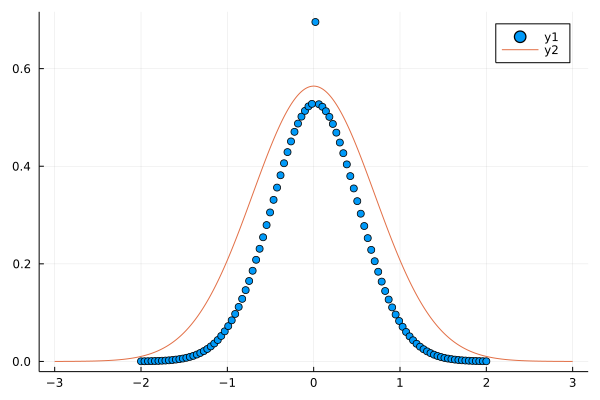

In [164]:
psi2 = psi/300
xlab = range(-2,2,length=100)

xr = range(-3,3,length=1000)

GS_wf(x) = exp(-x^2)/sqrt(pi)
plot(xlab,psi2,st=:scatter)
plot!(xr,GS_wf.(xr))

In [137]:
n_config

20000

In [138]:
Coeff

0.0025

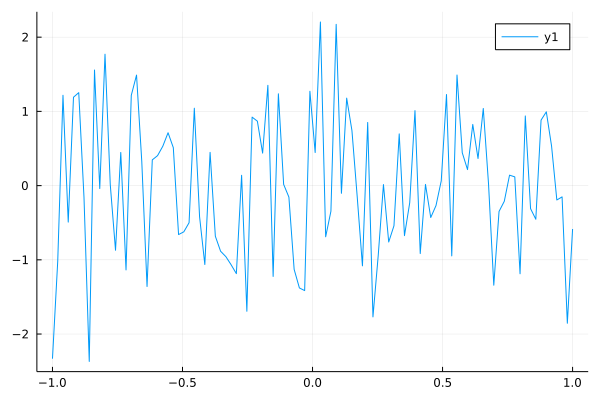

In [152]:


xlab = range(-1,1,length=100)

ylab = randn(100)


plot(xlab,ylab)